# Test Systems

Uses REBOUND commit 25f856dc2f79e0ad17b2f6bd604225f550593376

Test trained models on real non-resonant systems

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import rebound
import dask.dataframe as dd
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.style.use('paper.mplstyle')
%matplotlib inline

In [2]:
if rebound.__githash__ != '25f856dc2f79e0ad17b2f6bd604225f550593376':
    print('Should checkout commit above to ensure this runs correctly')

Should checkout commit above to ensure this runs correctly


In [5]:
path = '../data/TTVsystems/KOI-1576/simulation_archives/runs/'

In [4]:
from celmech import Andoyer

def get_k(row):
    sa = rebound.SimulationArchive(path+'sa'+row['runstring'])
    sim = sa[0]
    p2 = sim.particles[2]
    row['h'] = p2.e*np.sin(p2.pomega)
    row['k'] = p2.e*np.cos(p2.pomega)
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=5, k=1, i1=1, i2=2, average=False)
    row['Z12'] = avars.Z
    row['Zcom12'] = avars.Zcom
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=3, k=1, i1=2, i2=3, average=False)
    row['Z23'] = avars.Z
    row['Zcom23'] = avars.Zcom
    return row

In [6]:
trainpath = '../training_data/TTVsystems/KOI-1576/spock_featuresNorbits10000.0Nout80trio/'
labels = pd.read_csv(trainpath + 'labels.csv', index_col=0)
# Create k and h columns for plotting
labels['k'] = 0.
labels['h'] = 0.
labels['Z12'] = 0.
labels['Zcom12'] = 0.
labels['Z23'] = 0.
labels['Zcom23'] = 0.

In [7]:
%%time
dasklabels = dd.from_pandas(labels, npartitions=24)
dasklabels = dasklabels.apply(get_k, axis=1, meta=labels).compute(scheduler='processes')

CPU times: user 357 ms, sys: 349 ms, total: 706 ms
Wall time: 1.37 s


In [8]:
dasklabels.head()

,runstring,instability_time,shadow_instability_time,Stable,k,h,Z12,Zcom12,Z23,Zcom23
0,0000000.bin,1.929297e+08,1.000000e+09,False,0.054394,0.044154,0.006088,0.079240,0.115742,0.061535
1,0000001.bin,6.128830e+06,2.030558e+07,False,0.032373,-0.016926,0.006211,0.046958,0.140582,0.029636
2,0000002.bin,9.990000e+08,9.990000e+08,True,0.046896,-0.060405,0.006051,0.092534,0.143560,0.082526
3,0000003.bin,1.550988e+07,1.625084e+06,False,0.008657,-0.084850,0.005853,0.100416,0.093162,0.086720
4,0000004.bin,1.246694e+06,1.763933e+06,False,-0.003410,0.070536,0.006660,0.074416,0.130283,0.067658


In [9]:
from spock import spockClassifier

model = spockClassifier()
# Make predictions on the simulations using passed model
tdata = pd.read_csv(trainpath + 'trainingdata.csv', index_col=0)
tdata = tdata[model.features]

In [10]:
%%time
threshold=0.5
proba = model.predict_trio(tdata)
stablemask = dasklabels['Stable'] == True
unstablemask = dasklabels['Stable'] == False
pstablemask = proba > threshold
punstablemask = proba < threshold

CPU times: user 9.17 s, sys: 546 ms, total: 9.71 s
Wall time: 330 ms


In [11]:
stablemask.sum()

967

In [12]:
unstablemask.sum()

533

In [13]:
pstablemask.sum()

1428

In [14]:
FPR = 1-(punstablemask & unstablemask).sum()/unstablemask.sum()
FPR

0.8893058161350844

In [15]:
TPR = (pstablemask & stablemask).sum()/stablemask.sum()
TPR

0.9865563598759048

# fraction of unstable systems we  were able to. throw out

In [16]:
TNR = ((pstablemask == stablemask) & unstablemask).sum()/unstablemask.sum()
TNR

0.11069418386491557

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

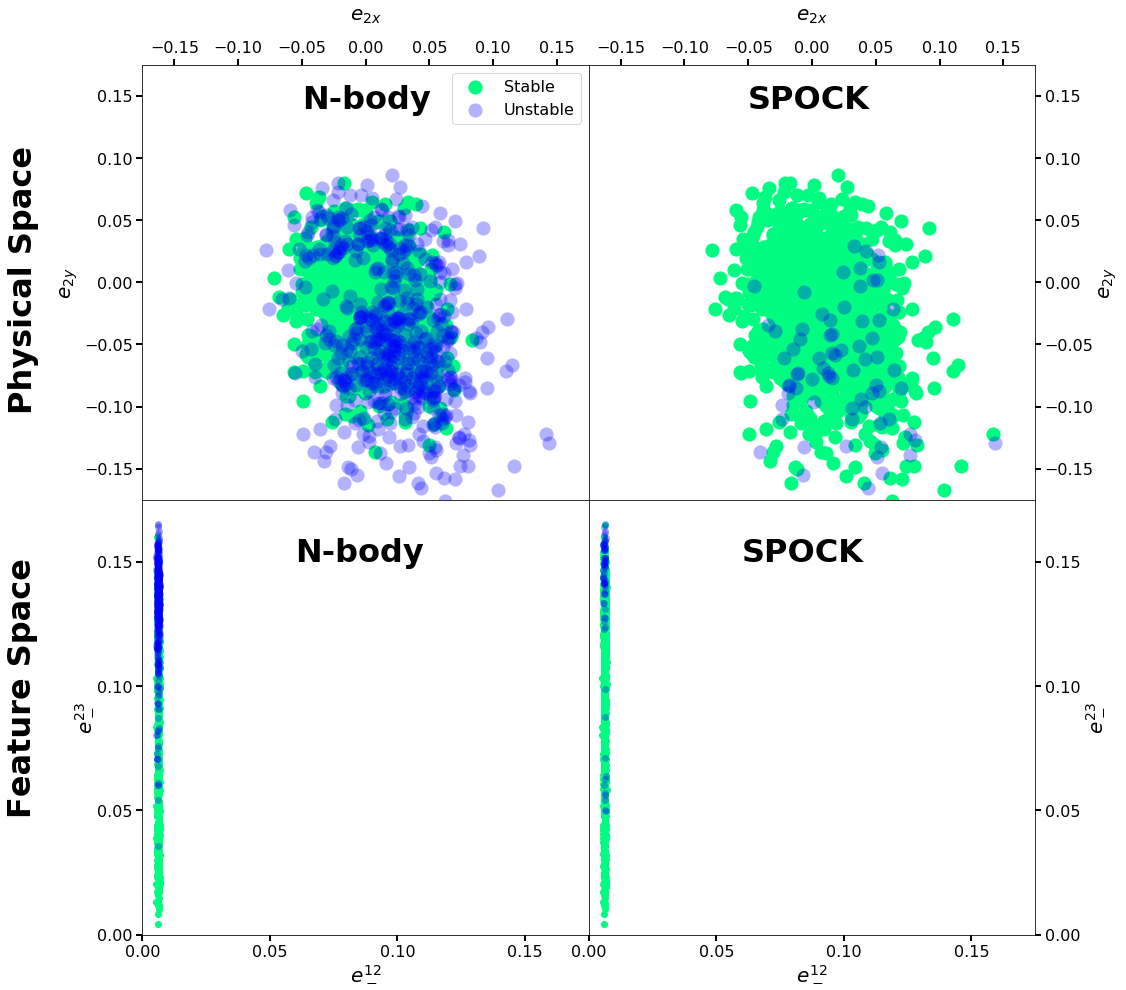

In [17]:
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=[16, 16])
plt.subplots_adjust(hspace=0, wspace=0)


colorbar = 'winter'
cmap = matplotlib.cm.get_cmap(colorbar)
s=200
axarr[0,0].scatter(dasklabels["k"][stablemask], dasklabels["h"][stablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[0,0].scatter(dasklabels["k"][unstablemask], dasklabels["h"][unstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[0,1].scatter(dasklabels["k"][pstablemask], dasklabels["h"][pstablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[0,1].scatter(dasklabels["k"][punstablemask], dasklabels["h"][punstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[0,1].tick_params(axis='y', which='both', left='off', right='off')
axarr[0,0].text(-0.05, 0.14, 'N-body', weight='bold', size=32)
axarr[0,1].text(-0.05, 0.14, 'SPOCK', weight='bold', size=32)
axarr[0,0].text(-0.28, -0.1, 'Physical Space', weight='bold', size=32, rotation=90)

lim = 0.175
axarr[0,0].set_xlim([-lim, lim])
axarr[0,0].set_ylim([-lim, lim])
axarr[0,1].set_xlim([-lim, lim])
axarr[0,1].set_ylim([-lim, lim])
axarr[0,0].legend()
axarr[0,1].yaxis.tick_right()
axarr[0,0].xaxis.tick_top()
axarr[0,1].xaxis.tick_top()


axarr[0,0].set_xlabel(r'$e_{2x}$', labelpad=20)
axarr[0,0].set_ylabel(r'$e_{2y}$')
axarr[0,1].set_xlabel(r'$e_{2x}$', labelpad=20)
axarr[0,1].set_ylabel(r'$e_{2y}$')
axarr[0,1].yaxis.set_label_position("right")
axarr[0,0].xaxis.set_label_position("top")
axarr[0,1].xaxis.set_label_position("top")


s=50
axarr[1,0].scatter(dasklabels["Z12"][stablemask], dasklabels["Z23"][stablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[1,0].scatter(dasklabels["Z12"][unstablemask], dasklabels["Z23"][unstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[1,1].scatter(dasklabels["Z12"][pstablemask], dasklabels["Z23"][pstablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[1,1].scatter(dasklabels["Z12"][punstablemask], dasklabels["Z23"][punstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[1,1].tick_params(axis='y', which='both', left='off', right='off')
axarr[1,0].text(0.06, 0.15, 'N-body', weight='bold', size=32)
axarr[1,1].text(0.06, 0.15, 'SPOCK', weight='bold', size=32)
axarr[1,0].text(-0.053, 0.05, 'Feature Space', weight='bold', size=32, rotation=90)


axarr[1,0].set_xlim([0, lim])
axarr[1,0].set_ylim([0, lim])
axarr[1,1].set_xlim([0, lim])
axarr[1,1].set_ylim([0, lim])
axarr[1,0].set_xticks([0, 0.05, 0.1, 0.15])
axarr[1,0].set_yticks([0, 0.05, 0.1, 0.15])
axarr[1,1].set_xticks([0, 0.05, 0.1, 0.15])
axarr[1,1].set_yticks([0, 0.05, 0.1, 0.15])
axarr[1,1].yaxis.tick_right()
axarr[1,1].yaxis.set_label_position("right")

axarr[1,0].set_xlabel(r'$e_-^{12}$')
axarr[1,0].set_ylabel(r'$e_-^{23}$')
axarr[1,1].set_xlabel(r'$e_-^{12}$')
axarr[1,1].set_ylabel(r'$e_-^{23}$')



fig.savefig('KOI1576.pdf', bbox_inches='tight')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

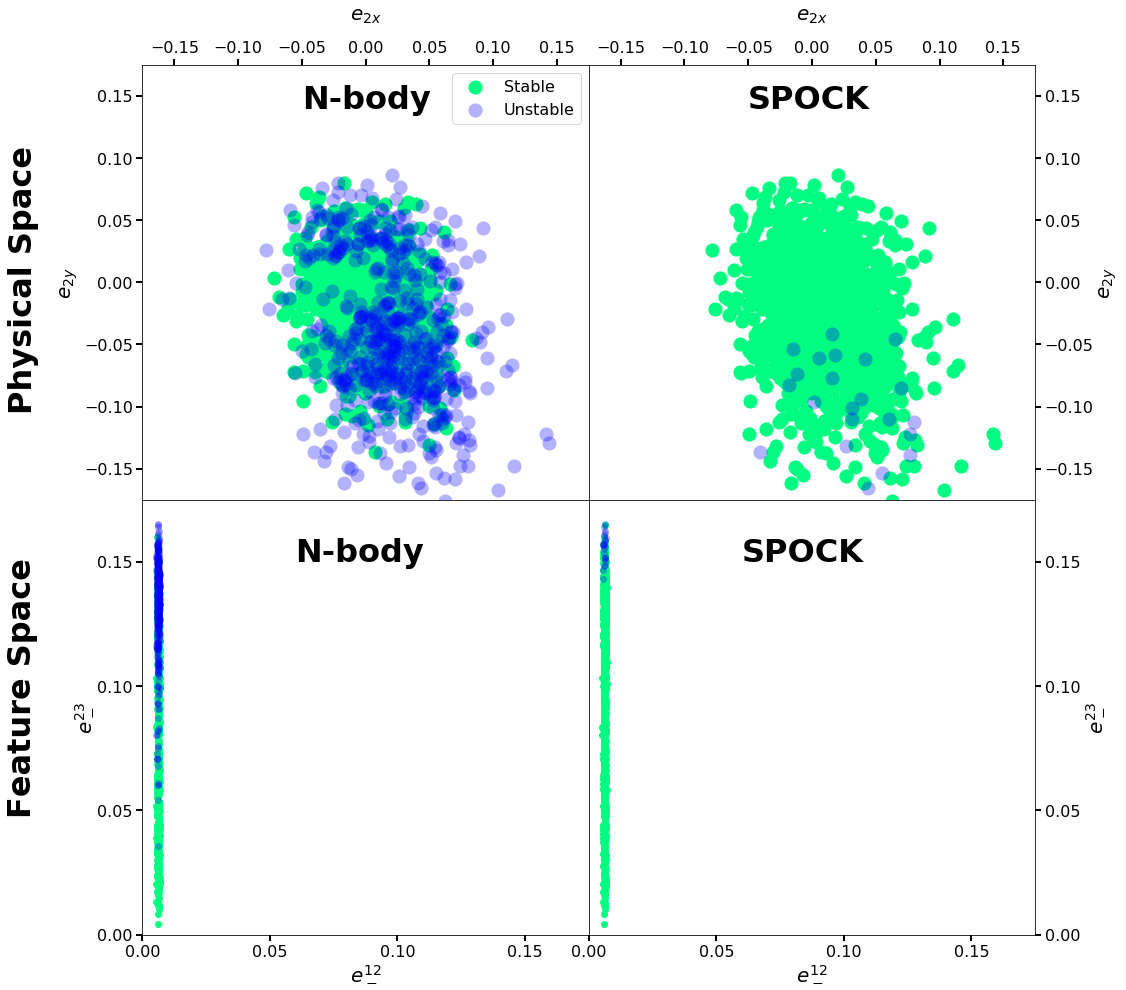

In [70]:
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=[16, 16])
plt.subplots_adjust(hspace=0, wspace=0)


colorbar = 'winter'
cmap = matplotlib.cm.get_cmap(colorbar)
s=200
axarr[0,0].scatter(dasklabels["k"][stablemask], dasklabels["h"][stablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[0,0].scatter(dasklabels["k"][unstablemask], dasklabels["h"][unstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[0,1].scatter(dasklabels["k"][pstablemask], dasklabels["h"][pstablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[0,1].scatter(dasklabels["k"][punstablemask], dasklabels["h"][punstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[0,1].tick_params(axis='y', which='both', left='off', right='off')
axarr[0,0].text(-0.05, 0.14, 'N-body', weight='bold', size=32)
axarr[0,1].text(-0.05, 0.14, 'SPOCK', weight='bold', size=32)
axarr[0,0].text(-0.28, -0.1, 'Physical Space', weight='bold', size=32, rotation=90)

lim = 0.175
axarr[0,0].set_xlim([-lim, lim])
axarr[0,0].set_ylim([-lim, lim])
axarr[0,1].set_xlim([-lim, lim])
axarr[0,1].set_ylim([-lim, lim])
axarr[0,0].legend()
axarr[0,1].yaxis.tick_right()
axarr[0,0].xaxis.tick_top()
axarr[0,1].xaxis.tick_top()


axarr[0,0].set_xlabel(r'$e_{2x}$', labelpad=20)
axarr[0,0].set_ylabel(r'$e_{2y}$')
axarr[0,1].set_xlabel(r'$e_{2x}$', labelpad=20)
axarr[0,1].set_ylabel(r'$e_{2y}$')
axarr[0,1].yaxis.set_label_position("right")
axarr[0,0].xaxis.set_label_position("top")
axarr[0,1].xaxis.set_label_position("top")


s=50
axarr[1,0].scatter(dasklabels["Z12"][stablemask], dasklabels["Z23"][stablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[1,0].scatter(dasklabels["Z12"][unstablemask], dasklabels["Z23"][unstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[1,1].scatter(dasklabels["Z12"][pstablemask], dasklabels["Z23"][pstablemask], c=cmap(0.99), s=s, lw=0, label='Stable')
axarr[1,1].scatter(dasklabels["Z12"][punstablemask], dasklabels["Z23"][punstablemask], c=cmap(0.), s=s, lw=0, label='Unstable', alpha=0.3)
axarr[1,1].tick_params(axis='y', which='both', left='off', right='off')
axarr[1,0].text(0.06, 0.15, 'N-body', weight='bold', size=32)
axarr[1,1].text(0.06, 0.15, 'SPOCK', weight='bold', size=32)
axarr[1,0].text(-0.053, 0.05, 'Feature Space', weight='bold', size=32, rotation=90)


axarr[1,0].set_xlim([0, lim])
axarr[1,0].set_ylim([0, lim])
axarr[1,1].set_xlim([0, lim])
axarr[1,1].set_ylim([0, lim])
axarr[1,0].set_xticks([0, 0.05, 0.1, 0.15])
axarr[1,0].set_yticks([0, 0.05, 0.1, 0.15])
axarr[1,1].set_xticks([0, 0.05, 0.1, 0.15])
axarr[1,1].set_yticks([0, 0.05, 0.1, 0.15])
axarr[1,1].yaxis.tick_right()
axarr[1,1].yaxis.set_label_position("right")

axarr[1,0].set_xlabel(r'$e_-^{12}$')
axarr[1,0].set_ylabel(r'$e_-^{23}$')
axarr[1,1].set_xlabel(r'$e_-^{12}$')
axarr[1,1].set_ylabel(r'$e_-^{23}$')



fig.savefig('KOI1576.pdf', bbox_inches='tight')

In [103]:
import sys
sys.path.append('../')
from modelfitting import ROC_curve

fprthresh = 0.1
tdata['megno'] = tdata['MEGNOmed']

name = 'MEGNO'
filename = 'megnoxgb_resonant'

model, features, featurefolder = dill.load(open(modelpath+filename+'.pkl', "rb"))
testingdatafolder = datapath+testing_dataset+'/'+featurefolder
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(testingdatafolder, model, features,  filtertimes=True)
threshindex = np.where(fpr > fprthresh)[0][0]
threshold = ROCthresholds[threshindex]

proba = model.predict_proba(pd.DataFrame(tdata['megno'], columns=['megno']))[:,1]
stablemask = dasklabels['Stable'] == True
unstablemask = dasklabels['Stable'] == False
pstablemask = proba > threshold
punstablemask = proba < threshold

FPR = 1-(punstablemask & unstablemask).sum()/unstablemask.sum()
TPR = (pstablemask & stablemask).sum()/stablemask.sum()

print(name, "thresh = {0:.3f}".format(threshold), "FPR = {0:.3f}".format(FPR), "TPR = {0:.3f}".format(TPR))
    

MEGNO thresh = 0.713 FPR = 0.597 TPR = 0.815


In [98]:
tdata

,AMDfracnear,AMDfracfar,AMDstdnear,AMDstdfar,EPstdnear,EPstdfar,EMfreestdnear,EMfracstdnear,EMfracstdfar,MEGNOmed,MEGNOstd,EMcrossnear,EMcrossfar,MMRhalfwidthnear,MMRstrengthnear,megno
0,1.435706,1.109938,0.001425,0.001102,0.001695,0.003470,NaN,0.024990,0.009910,1.999814,0.063385,0.163205,0.471772,NaN,0.079970,1.999814
1,0.498044,1.054410,0.001557,0.003297,0.000161,0.003075,NaN,0.020901,0.006915,2.003081,0.063941,0.163233,0.471753,NaN,0.080104,2.003081
2,1.939552,10.675098,0.001815,0.009992,0.000106,0.003637,NaN,0.027443,0.008301,2.003650,0.063698,0.163357,0.471745,NaN,0.088646,2.003650
3,1.846074,11.302966,0.001864,0.011414,0.000046,0.003317,NaN,0.028360,0.007273,1.999703,0.063681,0.163302,0.471559,NaN,0.087724,1.999703
4,0.998112,2.801502,0.001280,0.003591,0.000318,0.002926,NaN,0.024859,0.007355,1.995533,0.064217,0.163109,0.471832,NaN,0.059491,1.995533
5,0.262980,0.402538,0.001196,0.001831,0.000866,0.003006,NaN,0.015627,0.006844,2.000945,0.063267,0.163229,0.471792,NaN,0.055615,2.000945
6,1.954084,2.602056,0.001688,0.002248,0.001341,0.003761,NaN,0.027115,0.009900,1.998653,0.063983,0.163244,0.471798,NaN,0.087438,1.998653
7,1.313817,11.600122,0.001836,0.016206,0.000082,0.003515,NaN,0.026272,0.010779,2.002186,0.063403,0.163240,0.471729,NaN,0.087685,2.002186
8,5.104774,3.084764,0.002159,0.001305,0.001482,0.003617,NaN,0.030026,0.008129,2.011409,0.063984,0.163365,0.471606,NaN,0.091480,2.011409
9,4.962659,3.446875,0.002338,0.001624,0.000328,0.003133,NaN,0.033068,0.009933,2.000170,0.063230,0.163374,0.471543,NaN,0.101946,2.000170
